In [302]:
import os
import numpy as np
import librosa
import soundfile as sf
from basic_pitch.inference import predict
from basic_pitch import ICASSP_2022_MODEL_PATH
import music21
from pathlib import Path
from basic_pitch import constants as bp_constants
import pretty_midi
import scipy
HOP_LENGTH = bp_constants.FFT_HOP
SAMPLING_RATE = bp_constants.AUDIO_SAMPLE_RATE
MIDI_OFFSET = 21 # basic_pitchのピッチ配列のMIDIノート番号オフセット (=21, A0)
# 人が歌える音域の範囲
LOWEST_PITCH = 15 # C2 (MIDI 36)
HIGHEST_PITCH = 67 # E6 (MIDI 88)

# MuseScore 4のパスを明示的に設定
# ユーザーが確認したパス: /Applications/MuseScore4.app/Contents/MacOS/mscore
musescore_path = Path('/Applications/MuseScore 3.app/Contents/MacOS/mscore')

if musescore_path.exists():
    us = music21.environment.UserSettings()
    us['musicxmlPath'] = str(musescore_path)
    us['musescoreDirectPNGPath'] = str(musescore_path)
    
    print(f"MuseScore path successfully set to: {musescore_path}")
else:
    print(f"Warning: MuseScore not found at {musescore_path}. Please check the installation path.")

MuseScore path successfully set to: /Applications/MuseScore 3.app/Contents/MacOS/mscore


In [303]:
sound_name = "kyu_skmt"

data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
transcription_path = os.path.join(data_path, "processed", "transcribed", sound_name)
# 元の音声ファイル
original_file = os.path.join(data_path, "original", f"{sound_name}.mp4")
# 分離済みのボーカル音声ファイル
# input_file = os.path.join(data_path, "processed", "UVR", sound_name, f"{sound_name}_(Vocals)_UVR_MDXNET_KARA_(No Reverb)_UVR-DeEcho-DeReverb.wav")
input_file = os.path.join(data_path, "processed", "htdemucs", sound_name, "vocals.mp3")
# input_file = os.path.join(data_path, "processed", "htdemucs", sound_name, "vocals_(No Reverb)_UVR-DeEcho-DeReverb.wav")
inst_file = os.path.join(data_path, "processed", "UVR", sound_name, f"{sound_name}_(Instrumental)_UVR_MDXNET_KARA.wav")
inst_other_file = os.path.join(data_path, "processed", "htdemucs", sound_name, "other.mp3")
inst_bass_file = os.path.join(data_path, "processed", "htdemucs", sound_name, "bass.mp3")
inst_drum_file = os.path.join(data_path, "processed", "htdemucs", sound_name, "drums.mp3")
harmonic_file = os.path.join(transcription_path, f"{sound_name}_Harmonic.wav")
output_midi_path = os.path.join(transcription_path, 'vocals_transcribed.mid')

In [304]:
# 1. チューニング補正量を計算 (元の音源から)
# y_inst_raw, sr = librosa.load(inst_file)
# htdemucsの分離済みファイルを合成してインスト音源を作成 (リズム同期のため)
print("Constructing instrumental from htdemucs stems (other + bass + drums)...")
y_other, sr = librosa.load(inst_other_file) # defaults to sr=22050
y_bass, _ = librosa.load(inst_bass_file)
y_drums, _ = librosa.load(inst_drum_file)

# 長さを揃えてミックス
min_len = min(len(y_other), len(y_bass), len(y_drums))
y_inst_raw = y_other[:min_len] + y_bass[:min_len] + y_drums[:min_len]

tuning_offset = librosa.estimate_tuning(y=y_inst_raw, sr=sr)
print(f"Estimated tuning offset: {tuning_offset:.3f} bins")

# 2. リサンプリングでピッチ補正 (音質劣化なし・時間軸が変わる)
tuning_rate = 2 ** (-tuning_offset / 12)
print(f"Tuning rate: {tuning_rate:.4f}")

y_inst = librosa.resample(y_inst_raw, orig_sr=sr, target_sr=sr/tuning_rate)
print(f"Inst duration: {len(y_inst_raw)/sr:.2f}s -> {len(y_inst)/sr:.2f}s (resampled)")

Constructing instrumental from htdemucs stems (other + bass + drums)...
Estimated tuning offset: -0.070 bins
Tuning rate: 1.0041
Inst duration: 137.33s -> 136.77s (resampled)


In [ ]:
# 4. ボーカル音源も同じtuning_rateでリサンプリング
y_vocal_raw, sr = librosa.load(input_file)
if sr != SAMPLING_RATE:
    raise ValueError(f"Sample rate of input file ({sr}) does not match expected sample rate ({SAMPLING_RATE})")

y_vocal = librosa.resample(y_vocal_raw, orig_sr=sr, target_sr=sr/tuning_rate)
print(f"Vocal duration: {len(y_vocal_raw)/sr:.2f}s -> {len(y_vocal)/sr:.2f}s (resampled)")

# Harmonic/Percussive Source Separation (HPSS)
y_harmonic, _ = librosa.effects.hpss(y_vocal, margin=1.0)

# sr(=22050)で保存。basic_pitchが内部で22050Hzにリサンプリングするため一致させる。
sf.write(harmonic_file, y_harmonic, sr)
print(f"Saved harmonic component to {harmonic_file}")

# 3. リサンプリング後の音源からビート検出
tempo = librosa.feature.tempo(y=y_inst, sr=sr)
tempo, beat_track = librosa.beat.beat_track(y=y_inst, sr=sr, hop_length=HOP_LENGTH, start_bpm=tempo[0], units='frames')
print(f"Detected tempo: {float(tempo):.1f} BPM, {len(beat_track)} beats")

Vocal duration: 137.33s -> 136.77s (resampled)
Saved harmonic component to /Users/kpome/github/solfege-gen/data/processed/transcribed/kyu_skmt/kyu_skmt_Harmonic.wav
Detected tempo: 71.8 BPM, 161 beats


/var/folders/rv/hmpprb6j6y38jxsvwy_sqp7c0000gn/T/ipykernel_30711/3825508008.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Detected tempo: {float(tempo):.1f} BPM, {len(beat_track)} beats")


In [306]:
model_output, midi_data, _ = predict(
    harmonic_file,
    model_or_model_path=ICASSP_2022_MODEL_PATH,
    onset_threshold=0.5, # 無関係
    frame_threshold=0.3, # 無関係
    minimum_note_length=20, # 無関係
    maximum_frequency=2000,
    multiple_pitch_bends=False,
    melodia_trick=False,
    midi_tempo=float(tempo) # 無関係
    )
# MIDIデータをファイルに保存する
output_midi_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed', 'vocals_transcribed.mid')
midi_data.write(output_midi_path)
print(f"saved to {output_midi_path}")

Predicting MIDI for /Users/kpome/github/solfege-gen/data/processed/transcribed/kyu_skmt/kyu_skmt_Harmonic.wav...
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32


/var/folders/rv/hmpprb6j6y38jxsvwy_sqp7c0000gn/T/ipykernel_30711/3190278592.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  midi_tempo=float(tempo) # 無関係


isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844

In [307]:
# 1秒あたりのフレーム数を取得
# basic_pitchは内部で22050Hz/HOP_LENGTH=256でフレーム分割するため、SPFはこれに合わせる
SPF = HOP_LENGTH / SAMPLING_RATE
print(f"Seconds per frame: {SPF:.6f} sec/frame")
onsets_np = model_output['onset']  # shape: (num_frames, num_pitches)
print(f"onsets_np shape: {onsets_np.shape}")
pitches_np = model_output['note']  # shape: (num_frames, num_pitches)
print(f"pitches_np shape: {pitches_np.shape}")

Seconds per frame: 0.011610 sec/frame
onsets_np shape: (11762, 88)
pitches_np shape: (11762, 88)


In [ ]:
def quantize_to_grid(data, beat_track, subdivisions=4, agg_func=np.mean):
    """
    フレームデータをビートグリッドに量子化する．
    data: (num_frames, num_features)
    beat_track: ビートのフレームインデックス配列
    subdivisions: 1ビートあたりの分割数
    agg_func: 集約関数 (np.max, np.mean等). signature: func(array, axis=int)
    Returns: (grid_values, grid_frames)
    """
    end_frame = data.shape[0]
    grid_values = []
    grid_frames = []
    prev_beat_frame = 0

    for beat_frame in list(beat_track):
        sub_frames = np.linspace(prev_beat_frame, beat_frame, subdivisions + 1, dtype=int)
        for j in range(subdivisions):
            sf_start, sf_end = sub_frames[j], sub_frames[j + 1]
            if sf_end <= sf_start:
                continue
            sf_start = min(sf_start, end_frame)
            sf_end = min(sf_end, end_frame)
            
            if end_frame <= sf_start:
                grid_values.append(np.zeros(data.shape[1]))
            else:
                chunk = data[sf_start:sf_end]
                if chunk.shape[0] == 0:
                    grid_values.append(np.zeros(data.shape[1]))
                else:
                    grid_values.append(agg_func(chunk, axis=0))
            grid_frames.append(sf_start)
        prev_beat_frame = beat_frame

    # 最後のビート以降
    if prev_beat_frame < end_frame:
        sub_frames = np.linspace(prev_beat_frame, end_frame, subdivisions + 1, dtype=int)
        for j in range(subdivisions):
            sf_start, sf_end = sub_frames[j], sub_frames[j + 1]
            if sf_end <= sf_start:
                continue
            sf_start = min(sf_start, end_frame)
            sf_end = min(sf_end, end_frame)
            if sf_start < end_frame:
                grid_values.append(agg_func(data[sf_start:sf_end], axis=0))
            else:
                grid_values.append(np.zeros(data.shape[1]))
            grid_frames.append(sf_start)

    return np.array(grid_values), np.array(grid_frames)

def center_weighted_agg_func(array, axis=0):
    """
    配列の中心に重みを置いて集約する関数
    array: 入力配列
    axis: 集約する軸
    Returns: 集約結果
    """
    length = array.shape[axis]
    weights = np.hamming(length)
    weighted_array = array * weights[:, np.newaxis] if axis == 0 else array * weights[np.newaxis, :]
    return np.sum(weighted_array, axis=axis) / np.sum(weights)

def median_agg_func(array, axis=0):
    """
    配列の中央値を計算する関数
    array: 入力配列
    axis: 集約する軸
    Returns: 集約結果
    """
    return np.median(array, axis=axis)

# フレームをビートに合わせてグリッド化
SUBDIVISIONS = 4

# beat_trackはすでにリサンプリング後の時間軸で取得されているが
# basic_pitchの出力フレーム数(onsets_np)とy_instのフレーム数に微差があるため補正する
n_frames_inst = len(y_inst) / HOP_LENGTH
n_frames_basic = onsets_np.shape[0]
scale_factor = n_frames_basic / n_frames_inst

print(f"Frame scale factor: {scale_factor:.6f} (inst: {n_frames_inst:.1f} -> basic: {n_frames_basic})")

# beat_track のインデックスを basic_pitch のフレーム空間にマッピング
beat_track_scaled = beat_track * scale_factor

grid_onsets_np, grid_frames_np = quantize_to_grid(onsets_np, beat_track_scaled, SUBDIVISIONS, agg_func=np.max)
grid_notes_np, _ = quantize_to_grid(pitches_np, beat_track_scaled, SUBDIVISIONS, agg_func=center_weighted_agg_func)

print(f"grid_onsets_np shape: {grid_onsets_np.shape}, grid_notes_np shape: {grid_notes_np.shape}")

Frame scale factor: 0.998428 (inst: 11780.5 -> basic: 11762)


TypeError: slice indices must be integers or None or have an __index__ method

### HMMによるノート推定

#### キー推定

In [ ]:
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from collections import Counter

# キー推定用のクロマベクトル抽出
y_target_raw, sr = librosa.load(original_file, sr=sr)
y_target = librosa.resample(y_target_raw, orig_sr=sr, target_sr=sr/tuning_rate)
print(f"Target duration: {len(y_target_raw)/sr:.2f}s -> {len(y_target)/sr:.2f}s (resampled)")
y_target_harmonic, _ = librosa.effects.hpss(y_target, margin=1.0)

# クロマベクトルをCQTで抽出
chroma = librosa.feature.chroma_cqt(
    y=y_target_harmonic, 
    sr=sr, 
    hop_length=HOP_LENGTH, 
    fmin=librosa.note_to_hz('C1'), 
    n_octaves=7
)
chroma = chroma.T  # (num_frames, 12)
print(f"chroma shape: {chroma.shape}")

# クロマベクトルをビートグリッドに量子化
grid_chroma_np, _ = quantize_to_grid(chroma, beat_track, SUBDIVISIONS, agg_func=np.mean) # (num_grids, 12)
print(f"grid_chroma_np shape: {grid_chroma_np.shape}")

# 5. 平滑化フィルタの適用
filter_size = 16

# 移動平均 (Uniform Filter)
# grid_chroma_filtered = uniform_filter1d(grid_chroma_np, size=filter_size, axis=0, mode='nearest')
# print(f"grid_chroma_filtered shape: {grid_chroma_filtered.shape}")
# ガウシアンフィルタ
sigma = filter_size / 4
grid_chroma_filtered = gaussian_filter1d(grid_chroma_np, sigma=sigma, axis=0, mode='nearest')

Target duration: 137.27s -> 136.71s (resampled)


/var/folders/rv/hmpprb6j6y38jxsvwy_sqp7c0000gn/T/ipykernel_30711/2810387145.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y_target_raw, sr = librosa.load(original_file, sr=sr)
/Users/kpome/github/solfege-gen/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


chroma shape: (11776, 12)
grid_chroma_np shape: (648, 12)


In [ ]:
# 6. メジャー/マイナー両方のテンプレートを用意
# Krumhansl-Schmuckler Key Profiles
major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])

templates_major = np.array([np.roll(major_profile, i) for i in range(12)])
templates_minor = np.array([np.roll(minor_profile, i) for i in range(12)])
key_templates = np.vstack([templates_major, templates_minor])  # Shape: (24, 12)
template_centered = key_templates - key_templates.mean(axis=1, keepdims=True)
template_norm = template_centered / (np.linalg.norm(template_centered, axis=1, keepdims=True) + 1e-10)

# ラベル定義 (0-11: Major, 12-23: Minor)
KEY_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
FULL_KEY_LABELS = [f"{k} Major" for k in KEY_NAMES] + [f"{k} Minor" for k in KEY_NAMES]

# --- HMMの判定粒度設定 ---
# 4グリッド(=1拍)
BLOCK_SIZE = 4

# パディング（端数処理）
original_length = grid_chroma_filtered.shape[0]
pad_width = (BLOCK_SIZE - (original_length % BLOCK_SIZE)) % BLOCK_SIZE
padded_chroma = np.pad(grid_chroma_filtered, ((0, pad_width), (0, 0)), mode='edge')

# ダウンサンプリング (平均)
# shape: (num_blocks, 12)
coarse_chroma = padded_chroma.reshape(-1, BLOCK_SIZE, 12).mean(axis=1)
print(f"Coarse chroma shape: {coarse_chroma.shape} (Block size: {BLOCK_SIZE})")

# ピアソン相関係数 (Coarse grid)
chroma_centered = coarse_chroma - coarse_chroma.mean(axis=1, keepdims=True)
chroma_norm = chroma_centered / (np.linalg.norm(chroma_centered, axis=1, keepdims=True) + 1e-10)
correlation = chroma_norm @ template_norm.T

# --- Feature: Global Key Bias ---
# 曲全体の相関和が最も高いキーを「Global Key」と仮定し、
# 確率分布においてそのキーを優遇する（Prior Bias）
total_correlation = correlation.sum(axis=0)
global_key_idx = np.argmax(total_correlation)
print(f"Global Key Hint: {FULL_KEY_LABELS[global_key_idx]}")

# 確率変換
temperature = 1.0
key_prob = np.exp(correlation / temperature)

# 正規化
key_prob /= np.sum(key_prob, axis=1, keepdims=True)

# HMMパラメータ
n_states = 24
transition = np.full((n_states, n_states), 0.001) # ベース確率

STABLE_PROB = 0.90
RELATIVE_PROB = 0.05
FIFTH_TRANSITION_PROB = 0.01
PARALLEL_TRANSITION_PROB = 0.003

for i in range(12):
    # --- Major Key (i) からの遷移 ---
    transition[i, i] = STABLE_PROB             # 自己遷移
    
    # 属調・下属調 (Major)
    transition[i, (i + 7) % 12] = FIFTH_TRANSITION_PROB
    transition[i, (i + 5) % 12] = FIFTH_TRANSITION_PROB
    
    # 平行調 (Relative Minor): 3半音下
    rel_min = 12 + (i - 3) % 12
    transition[i, rel_min] = RELATIVE_PROB
    
    # 同主調 (Parallel Minor)
    para_min = 12 + i
    transition[i, para_min] = PARALLEL_TRANSITION_PROB

    # --- Minor Key (12+i) からの遷移 ---
    m = 12 + i
    transition[m, m] = STABLE_PROB             # 自己遷移
    
    # 属調・下属調 (Minor)
    transition[m, 12 + (i + 7) % 12] = FIFTH_TRANSITION_PROB
    transition[m, 12 + (i + 5) % 12] = FIFTH_TRANSITION_PROB
    
    # 平行調 (Relative Major): 3半音上
    rel_maj = (i + 3) % 12
    transition[m, rel_maj] = RELATIVE_PROB
    
    # 同主調 (Parallel Major)
    transition[m, i] = PARALLEL_TRANSITION_PROB

transition /= transition.sum(axis=1, keepdims=True)

# Viterbi実行 (Coarse)
# 初期確率もGlobal Keyに偏らせる
p_init = np.ones(n_states) * 0.1
p_init[global_key_idx] = 0.30
p_init /= p_init.sum()

# Viterbiアルゴリズムで最適キー系列を推定
key_sequence_coarse = librosa.sequence.viterbi(key_prob.T, transition, p_init=p_init)

# 結果を元の解像度に復元
key_sequence = np.repeat(key_sequence_coarse, BLOCK_SIZE)[:original_length]

# 出力
key_counts = Counter([FULL_KEY_LABELS[k] for k in key_sequence])

print(f"\n推定キー分布 (Block-wise + Global Bias):")
for key, count in key_counts.most_common():
    print(f"  {key}: {count} grids ({100*count/original_length:.1f}%)")

print(f"\n推定キー系列 (Head):")
for i in range(min(5, len(key_sequence))):
    print(f"  Grid {i:4d}: {FULL_KEY_LABELS[key_sequence[i]]}")

Coarse chroma shape: (162, 12) (Block size: 4)
Global Key Hint: A Major

推定キー分布 (Block-wise + Global Bias):
  A Major: 648 grids (100.0%)

推定キー系列 (Head):
  Grid    0: A Major
  Grid    1: A Major
  Grid    2: A Major
  Grid    3: A Major
  Grid    4: A Major


#### ノート推定

##### 準備

In [ ]:
# --- キー情報を用いたノート確率の押し上げ ---
def get_scale_mask(key_idx, n_pitches=88, midi_offset=21):
    """
    指定されたキーのスケール構成音に高い重みを、それ以外に低い重みを返す.
    key_idx: 0-11 = Major, 12-23 = Minor
    n_pitches: ピッチ数 (basic_pitch = 88)
    Returns: (n_pitches,) の重み配列
    """
    
    # 主音
    root = key_idx % 12
    is_minor = key_idx >= 12
    
    if is_minor:
        intervals = {0, 2, 3, 5, 7, 8, 10} # Minor
    else:
        intervals = {0, 2, 4, 5, 7, 9, 11}  # Major
    
    mask = np.ones(n_pitches)  # +1 for Rest
    
    for i in range(n_pitches):
        midi_note = i + midi_offset
        pitch_class = midi_note % 12
        # ルートからの相対音高を計算
        relative_pitch = (pitch_class - root + 12) % 12
        
        if relative_pitch in intervals:
            mask[i] = 1.2   # スケール内の音を優遇
        elif is_minor and relative_pitch in {6, 11}:
            mask[i] = 0.9   # メロディックマイナーの特徴音
        else:
            mask[i] = 0.6   # スケール外の音を抑制
    
    return mask

n_grids, n_note_states = grid_notes_np.shape

# key_sequence の長さを n_grids に合わせる (安全策)
if len(key_sequence) < n_grids:
    print(f"Warning: key_sequence ({len(key_sequence)}) < n_grids ({n_grids}). Padding.")
    key_sequence_padded = np.pad(key_sequence, (0, n_grids - len(key_sequence)), mode='edge')
elif len(key_sequence) > n_grids:
    key_sequence_padded = key_sequence[:n_grids]
else:
    key_sequence_padded = key_sequence

# 確率にキーのバイアスを適用
biased_notes_prob = grid_notes_np.copy()
biased_onsets_prob = grid_onsets_np.copy()
for t in range(n_grids):
    mask = get_scale_mask(key_sequence_padded[t], n_note_states, MIDI_OFFSET)
    biased_notes_prob[t] *= mask
    biased_onsets_prob[t] *= mask

In [ ]:
# --- キー情報により補正されたノート確率を用いて各グリッドに音を割り当て ---
def save_grid_to_midi(grid_onsets_np, grid_notes_np, grid_frames_np, spf, onset_threshold=0.50, pitch_threshold=0.33, output_filename="output.mid"):
    """
    grid_onsets_np: (num_grids, num_pitches) - 各グリッドのonset確率
    grid_notes_np:  (num_grids, num_pitches) - 各グリッドのnote確率
    grid_frames_np: (num_grids,) - 各グリッドの開始フレーム
    spf: seconds per frame

    Returns:
        assigned_pitch: (num_grids, num_pitches)
            各グリッドでpitchが割り当てられた場合はそのpitchを1.0にしたベクトル、
            割り当てられない場合は元のgrid_notes_npの値を保持
    """
    if grid_onsets_np.shape != grid_notes_np.shape:
        raise ValueError("grid_onsets_np and grid_notes_np must have the same shape")
    if grid_onsets_np.shape[0] != len(grid_frames_np):
        raise ValueError("grid count and grid_frames length must match")
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)
    
    active_note_start_time = None
    active_pitch = None
    num_grids = grid_onsets_np.shape[0]
    print(f"grid_onsets_np shape: {grid_onsets_np.shape}, grid_notes_np shape: {grid_notes_np.shape}")

    # 出力用: 割り当てなしグリッドは元の確率を保持
    assigned_pitch = grid_notes_np.copy()
    
    for i in range(num_grids):
        onset = grid_onsets_np[i]
        pitch = grid_notes_np[i]
        grid_time = grid_frames_np[i] * spf
        
        detected_onset = (np.argmax(onset) + MIDI_OFFSET) if np.max(onset) >= onset_threshold else None
        detected_pitch = (np.argmax(pitch) + MIDI_OFFSET) if np.max(pitch) >= pitch_threshold else None

        # --- 1. 終了判定 (Note Off) ---
        if active_pitch is not None:
            should_close = (
                (detected_pitch is None) or 
                (detected_pitch != active_pitch) or 
                (detected_onset is not None)
            )
            if should_close:
                note = pretty_midi.Note(
                    velocity=50,
                    pitch=int(active_pitch),
                    start=active_note_start_time,
                    end=grid_time
                )
                instrument.notes.append(note)
                active_pitch = None
                active_note_start_time = None

        # --- 2. 開始判定 (Note On) ---
        if active_pitch is None and detected_pitch is not None:
            active_pitch = detected_pitch
            active_note_start_time = grid_time

        # --- 3. グリッドへの割り当て出力 ---
        # その時点でactive_pitchが存在するなら、そのグリッドはそのpitchに確定(1.0)
        # 割り当てがない場合はassigned_pitch[i]は初期値(元の確率)のまま
        if active_pitch is not None:
            assigned_pitch[i] = np.zeros_like(assigned_pitch[i])
            assigned_pitch[i][active_pitch - MIDI_OFFSET] = 1.0

    # --- 4. 後処理 ---
    if active_pitch is not None:
        end_time = (grid_frames_np[-1] + (grid_frames_np[-1] - grid_frames_np[-2])) * spf if num_grids > 1 else grid_frames_np[-1] * spf
        note = pretty_midi.Note(
            velocity=50,
            pitch=int(active_pitch),
            start=active_note_start_time,
            end=end_time
        )
        instrument.notes.append(note)

    pm.instruments.append(instrument)
    pm.write(output_filename)
    print(f"Saved MIDI to {output_filename} ({len(instrument.notes)} notes)")

    return assigned_pitch

# ノート推定を行い，HMMにおける輪郭を作成
assigned_pitch = save_grid_to_midi(
    biased_onsets_prob,
    biased_notes_prob,
    grid_frames_np,
    SPF,
    pitch_threshold=0.35,
    output_filename="transcribed_output.mid"
)
print(f"assigned_pitch shape: {assigned_pitch.shape}")

grid_onsets_np shape: (648, 88), grid_notes_np shape: (648, 88)
Saved MIDI to transcribed_output.mid (344 notes)
assigned_pitch shape: (648, 88)


R median: 0.0282, mean: 0.1063, max: 0.9668
notes_in_range shape: (648, 53)  (pitch bins: 15..67)
pitch_profiles shape: (648, 53)  (temporally smoothed)
Recurrence stats: max=0.9668, threshold=0.3182 (Top 90.0%)
motif candidates: all=11, selected=9
[01] A:151-173 (32.1s-37.0s) B:280-302 (59.2s-64.0s) len=23 (4.8s) score=0.5738
[02] A:101-113 (21.7s-24.4s) B:230-242 (48.7s-51.4s) len=13 (2.7s) score=0.7233
[03] A:428-437 (90.2s-92.3s) B:444-453 (93.5s-95.6s) len=10 (2.1s) score=0.6777
[04] A:425-435 (89.6s-91.9s) B:554-564 (116.6s-118.9s) len=11 (2.3s) score=0.5639
[05] A:194-202 (41.1s-43.0s) B:323-331 (68.2s-70.1s) len=9 (1.9s) score=0.6657
[06] A:427-435 (90.0s-91.9s) B:572-580 (120.4s-122.2s) len=9 (1.9s) score=0.6431
[07] A:445-454 (93.8s-95.9s) B:558-567 (117.4s-119.5s) len=10 (2.1s) score=0.5109
[08] A:334-343 (70.5s-72.6s) B:624-633 (131.3s-133.4s) len=10 (2.1s) score=0.4973
[09] A:459-466 (96.7s-98.4s) B:588-595 (123.7s-125.4s) len=8 (1.7s) score=0.4957


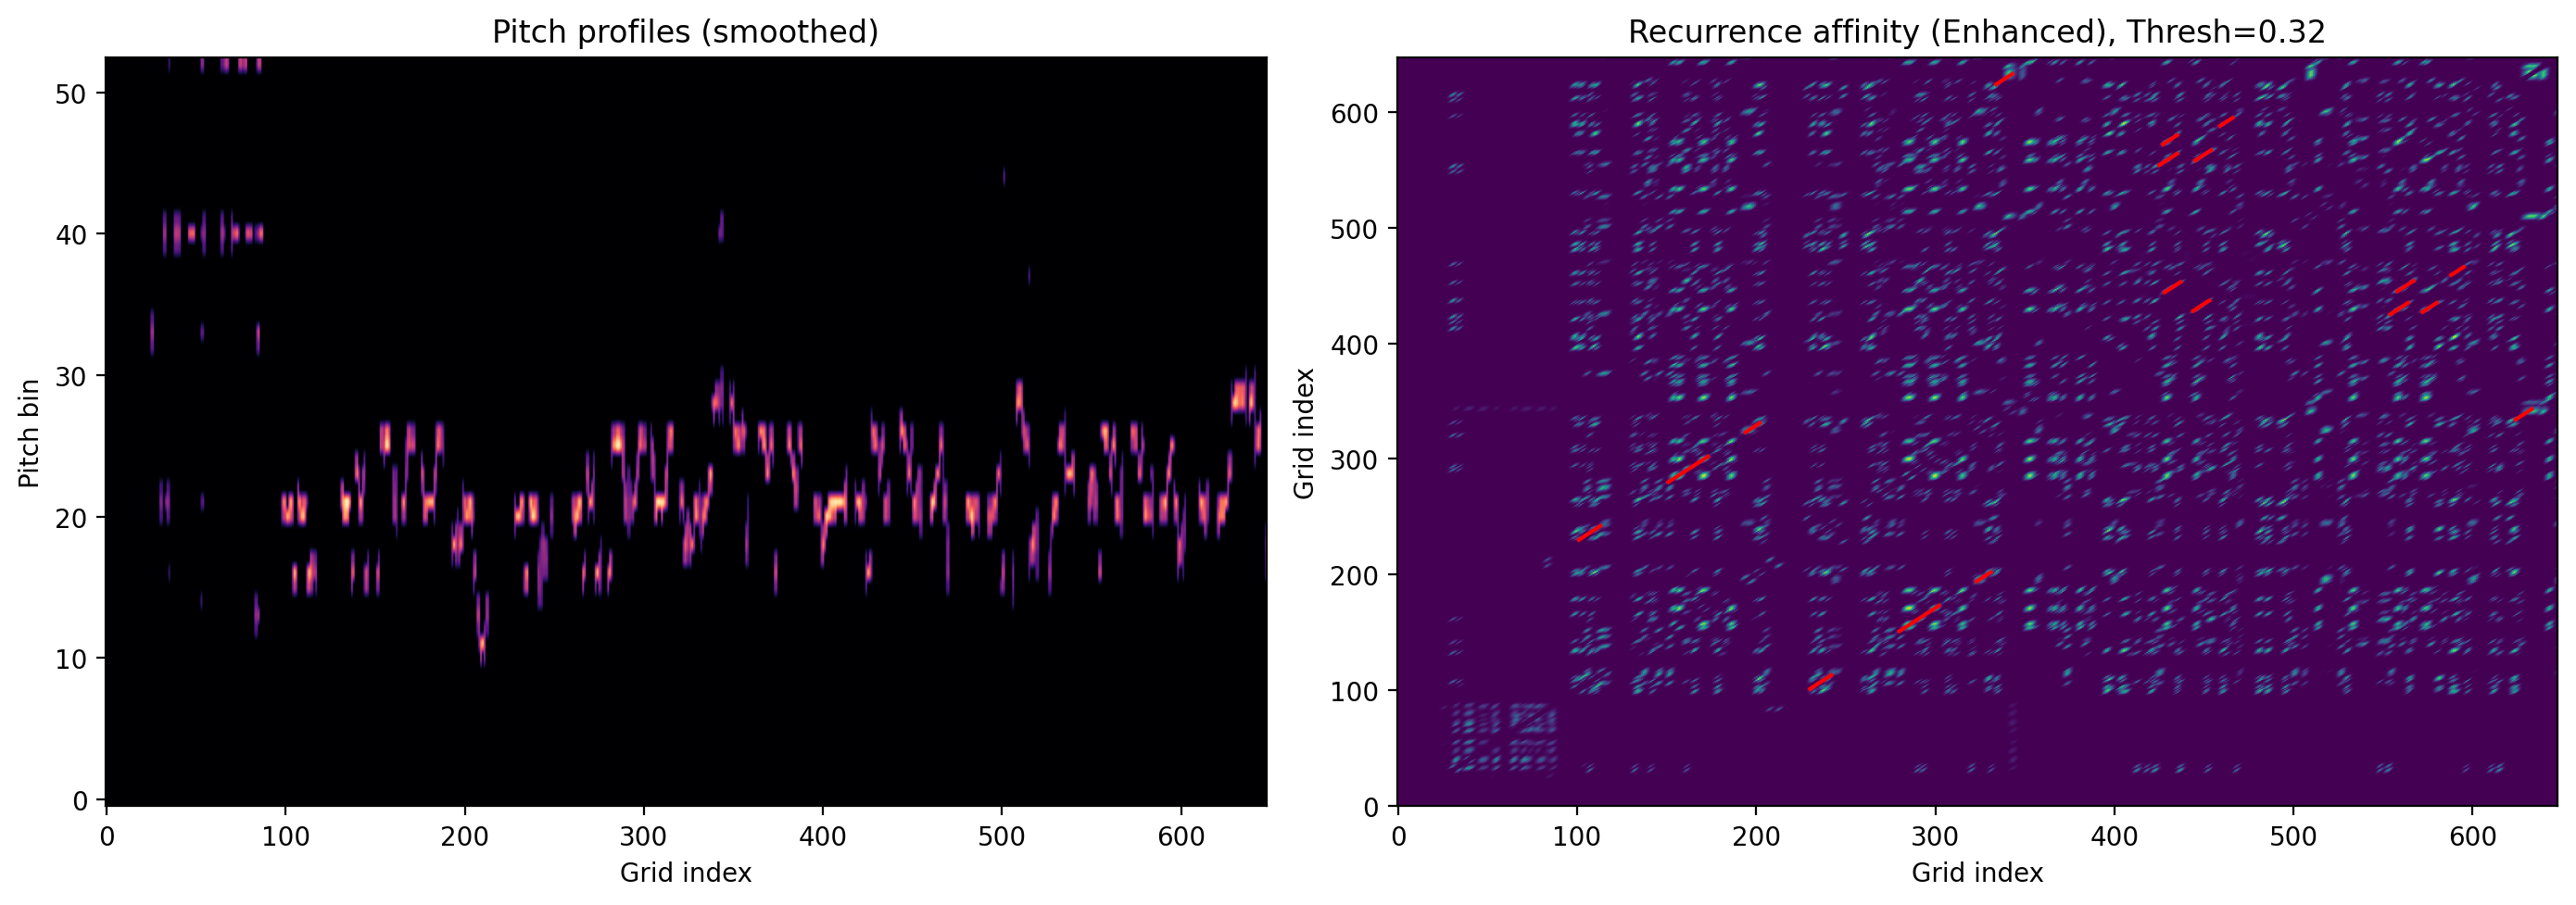

In [ ]:
# --- モチーフ抽出: 元ピッチ分布を直接使用（休符なし・音域制限あり） ---
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d, uniform_filter1d, median_filter, gaussian_filter1d
import scipy.ndimage

# 設定
REC_WIDTH = 3                   # 近傍自己一致の除外幅
REC_MIN_LEN = 8                 # Motif length threshold
REC_Q = 0.90                    # Top Q%

# 1) 入力: biased_notes_prob を歌唱音域内に制限
pitch_lo = LOWEST_PITCH
pitch_hi = HIGHEST_PITCH
if not (0 <= pitch_lo <= pitch_hi < biased_notes_prob.shape[1]):
    raise ValueError("LOWEST_PITCH/HIGHEST_PITCH out of range for biased_notes_prob")

# 歌唱音域内の確率分布を抽出（元ピッチ）
notes_in_range = np.array(biased_notes_prob[:, pitch_lo:pitch_hi + 1], dtype=np.float64, copy=True)
notes_in_range[notes_in_range < 0] = 0.0

T, P = notes_in_range.shape
if T < 2:
    raise ValueError("Need at least 2 grids to compute recurrence")

# 2) 特徴量: 音程差ではなく元ピッチ分布を直接使用
pitch_profiles = notes_in_range.copy()

# 3) 平滑化
# 3-a) 局所平滑化（ピッチ軸方向）
pitch_profiles = gaussian_filter1d(pitch_profiles, sigma=0.8, axis=1, mode="nearest")

# 3-b) 時間軸方向の平滑化
pitch_profiles = uniform_filter1d(pitch_profiles, size=2, axis=0, mode="nearest")

# 3-c) ハード・スレッショルド (Noise Gating)
peak_values = pitch_profiles.max(axis=1, keepdims=True)
mask = pitch_profiles < (peak_values * 0.6)
pitch_profiles[mask] = 0.0

# 3-d) コントラスト強調 (Power)
pitch_profiles = np.power(pitch_profiles, 1)

# 平坦フレーム抑制
peak_strength = pitch_profiles.max(axis=1)
threshold_strength = np.mean(peak_values) * 0.7
flat_noise_mask = peak_strength < threshold_strength
pitch_profiles[flat_noise_mask] = 0.0

# L2正規化
norms = np.linalg.norm(pitch_profiles, axis=1, keepdims=True)
norms[norms == 0] = 1.0
pitch_features = pitch_profiles / norms

# 後段セルとの互換のために保持
interval_profiles = pitch_profiles
interval_features = pitch_features

# 4) Recurrence Matrix
rec_input = interval_features.T  # shape: (features, time)
R = librosa.segment.recurrence_matrix(
    rec_input,
    k=None,
    width=REC_WIDTH,
    metric="cosine",
    mode="affinity",
    sym=True,
    sparse=False,
)

# --- 対角線強調 (Lag-Smoothing) ---
R_enhanced = librosa.segment.timelag_filter(gaussian_filter1d)(R, sigma=1.2, mode='mirror')
np.fill_diagonal(R_enhanced, 0.0)

# しきい値処理
valid_vals = R_enhanced[R_enhanced > 0]
print(f"R median: {np.median(valid_vals):.4f}, mean: {np.mean(valid_vals):.4f}, max: {R_enhanced.max():.4f}")
if valid_vals.size == 0:
    rec_threshold = 1.0
    print("Warning: No positive affinity pairs found in enhanced matrix.")
else:
    # 上位 Q%
    rec_threshold = np.percentile(valid_vals, REC_Q * 100)

R_bin = (R_enhanced >= rec_threshold).astype(np.uint8)

def extract_diagonal_runs(R_aff, R_binary, min_len=8, min_offset=4):
    n = R_binary.shape[0]
    segments = []
    for offset in range(min_offset, n):
        diag_bin = np.diagonal(R_binary, offset=offset)
        if diag_bin.size < min_len:
            continue

        # ランレングス圧縮で高速化
        padded = np.concatenate(([0], diag_bin, [0]))
        diffs = np.diff(padded)
        starts = np.where(diffs == 1)[0]
        ends = np.where(diffs == -1)[0]

        for start, end in zip(starts, ends):
            length = end - start
            if length >= min_len:
                a0 = start
                b0 = start + offset
                diag_aff = np.diagonal(R_aff, offset=offset)
                score = float(np.mean(diag_aff[start:end]))
                segments.append({
                    "start_a": int(a0),
                    "start_b": int(b0),
                    "length": int(length),
                    "score": score,
                })

    segments.sort(key=lambda s: (s["score"] * s["length"], s["length"]), reverse=True)
    return segments

def overlap_1d(a0, a1, b0, b1):
    return not (a1 <= b0 or b1 <= a0)

def select_non_overlapping(segments, top_k=20):
    selected = []
    for seg in segments:
        a0, a1 = seg["start_a"], seg["start_a"] + seg["length"]
        b0, b1 = seg["start_b"], seg["start_b"] + seg["length"]

        # 追加: A区間とB区間自体が重なっている場合は除外（自己重複排除）
        if overlap_1d(a0, a1, b0, b1):
            continue

        ok = True
        for kept in selected:
            ka0, ka1 = kept["start_a"], kept["start_a"] + kept["length"]
            kb0, kb1 = kept["start_b"], kept["start_b"] + kept["length"]
            # 既存の選択済みモチーフと「AもBも被っている」ものは重複とみなす
            if overlap_1d(a0, a1, ka0, ka1) and overlap_1d(b0, b1, kb0, kb1):
                ok = False
                break
        if ok:
            selected.append(seg)
        if len(selected) >= top_k:
            break
    return selected

motif_candidates_all = extract_diagonal_runs(
    R_aff=R_enhanced,
    R_binary=R_bin,
    min_len=REC_MIN_LEN,
    min_offset=REC_WIDTH,
)
motif_segments = select_non_overlapping(motif_candidates_all, top_k=100)

# 後段で使うために保持
motif_interval_profiles = interval_profiles
motif_recurrence_affinity = R_enhanced
motif_recurrence_binary = R_bin

print(f"notes_in_range shape: {notes_in_range.shape}  (pitch bins: {pitch_lo}..{pitch_hi})")
print(f"pitch_profiles shape: {pitch_profiles.shape}  (temporally smoothed)")
print(f"Recurrence stats: max={R_enhanced.max():.4f}, threshold={rec_threshold:.4f} (Top {REC_Q*100}%)")
print(f"motif candidates: all={len(motif_candidates_all)}, selected={len(motif_segments)}")

# グリッド→秒の変換テーブルを事前計算
grid_times_sec = librosa.frames_to_time(grid_frames_np, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)

for idx, seg in enumerate(motif_segments, start=1):
    a0 = seg['start_a']
    aL = min(seg['start_a'] + seg['length'], len(grid_times_sec) - 1)
    b0 = seg['start_b']
    bL = min(seg['start_b'] + seg['length'], len(grid_times_sec) - 1)
    print(
        f"[{idx:02d}] A:{a0}-{a0 + seg['length'] - 1} "
        f"({grid_times_sec[a0]:.1f}s-{grid_times_sec[aL]:.1f}s) "
        f"B:{b0}-{b0 + seg['length'] - 1} "
        f"({grid_times_sec[b0]:.1f}s-{grid_times_sec[bL]:.1f}s) "
        f"len={seg['length']} ({grid_times_sec[aL] - grid_times_sec[a0]:.1f}s) "
        f"score={seg['score']:.4f}"
    )

# 5) 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(pitch_profiles.T, aspect="auto", origin="lower", cmap="magma")
axes[0].set_title("Pitch profiles (smoothed)")
axes[0].set_xlabel("Grid index")
axes[0].set_ylabel("Pitch bin")

axes[1].imshow(R_enhanced, aspect="auto", origin="lower", cmap="viridis")
axes[1].set_title(f"Recurrence affinity (Enhanced), Thresh={rec_threshold:.2f}")
axes[1].set_xlabel("Grid index")
axes[1].set_ylabel("Grid index")

for seg in motif_segments[:10]:
    a0 = seg["start_a"]
    b0 = seg["start_b"]
    L = seg["length"]
    axes[1].plot([b0, b0 + L - 1], [a0, a0 + L - 1], color="red", linewidth=1.5)
    axes[1].plot([a0, a0 + L - 1], [b0, b0 + L - 1], color="red", linewidth=1.5)

plt.tight_layout()
plt.show()

In [ ]:
# --- モチーフを考慮したノート確率の補正 ---
# motif_segments の各ペア (A, B) について、対応するグリッド間で確率の重み付き和を取る
# 元の確率の重み: W_SELF=0.8, モチーフ対応側の重み: W_MOTIF=0.2

W_SELF = 0.6
W_MOTIF = 0.4

n_grids_total = biased_notes_prob.shape[0]

# モチーフ対応側からの寄与を蓄積
motif_contributions = np.zeros_like(biased_notes_prob)
motif_counts = np.zeros(n_grids_total, dtype=np.float64)

for seg in motif_segments:
    a0 = seg['start_a']
    b0 = seg['start_b']
    L = seg['length']

    # 有効範囲にクリップ
    valid_len = min(L, n_grids_total - a0, n_grids_total - b0)
    if valid_len <= 0:
        continue

    a_slice = slice(a0, a0 + valid_len)
    b_slice = slice(b0, b0 + valid_len)

    # A側 ← B側の確率を寄与として加算
    motif_contributions[a_slice] += biased_notes_prob[b_slice]
    motif_counts[a0:a0 + valid_len] += 1

    # B側 ← A側の確率を寄与として加算
    motif_contributions[b_slice] += biased_notes_prob[a_slice]
    motif_counts[b0:b0 + valid_len] += 1

# モチーフ対応があるグリッドのみ補正
has_motif = motif_counts > 0
corrected_notes_prob = biased_notes_prob.copy()

if has_motif.any():
    # 複数モチーフにマッチした場合は平均を取る
    avg_motif_prob = motif_contributions[has_motif] / motif_counts[has_motif, np.newaxis]
    corrected_notes_prob[has_motif] = W_SELF * biased_notes_prob[has_motif] + W_MOTIF * avg_motif_prob

n_corrected = has_motif.sum()
print(f"モチーフ補正: {n_corrected}/{n_grids_total} grids corrected "
      f"(W_SELF={W_SELF}, W_MOTIF={W_MOTIF})")
print(f"  motif_segments used: {len(motif_segments)}")

# 後段で使用するために biased_notes_prob を更新
biased_notes_prob = corrected_notes_prob

モチーフ補正: 173/648 grids corrected (W_SELF=0.6, W_MOTIF=0.4)
  motif_segments used: 9


In [ ]:
# ノート推定を行い，HMMにおける輪郭を作成
assigned_pitch = save_grid_to_midi(
    biased_onsets_prob,
    biased_notes_prob,
    grid_frames_np,
    SPF,
    pitch_threshold=0.40,
    output_filename="transcribed_output_motif.mid"
)

grid_onsets_np shape: (648, 88), grid_notes_np shape: (648, 88)
Saved MIDI to transcribed_output_motif.mid (321 notes)


#### キーに基づくノート推定 Dynamic Programming

In [ ]:
# --- assigned_pitch にモチーフ補正を適用 ---
# assigned_pitch: 割り当て済みグリッドは1.0, 未割り当ては元の確率
# motif_segments の対応ペア間で重み付き和を取る

W_SELF_AP = 0.6
W_MOTIF_AP = 0.4

n_grids_ap = assigned_pitch.shape[0]

motif_contrib_ap = np.zeros_like(assigned_pitch)
motif_count_ap = np.zeros(n_grids_ap, dtype=np.float64)

for seg in motif_segments:
    a0 = seg['start_a']
    b0 = seg['start_b']
    L = seg['length']
    valid_len = min(L, n_grids_ap - a0, n_grids_ap - b0)
    if valid_len <= 0:
        continue

    a_sl = slice(a0, a0 + valid_len)
    b_sl = slice(b0, b0 + valid_len)

    motif_contrib_ap[a_sl] += assigned_pitch[b_sl]
    motif_count_ap[a0:a0 + valid_len] += 1

    motif_contrib_ap[b_sl] += assigned_pitch[a_sl]
    motif_count_ap[b0:b0 + valid_len] += 1

has_motif_ap = motif_count_ap > 0
assigned_pitch_corrected = assigned_pitch.copy()

if has_motif_ap.any():
    avg_motif_ap = motif_contrib_ap[has_motif_ap] / motif_count_ap[has_motif_ap, np.newaxis]
    assigned_pitch_corrected[has_motif_ap] = (
        W_SELF_AP * assigned_pitch[has_motif_ap] + W_MOTIF_AP * avg_motif_ap
    )

n_corr_ap = has_motif_ap.sum()
print(f"assigned_pitch モチーフ補正: {n_corr_ap}/{n_grids_ap} grids "
      f"(W_SELF={W_SELF_AP}, W_MOTIF={W_MOTIF_AP})")

# --- HMM入力の準備 ---
grid_notes_prob_np = assigned_pitch_corrected.copy()
# 人が歌える音域外の音を除去
grid_notes_prob_np[:, :LOWEST_PITCH] = -np.inf
grid_notes_prob_np[:, HIGHEST_PITCH + 1:] = -np.inf
# 無音の確率を追加
temperature = 0.8
rest_prob = np.expand_dims(np.ones(grid_notes_prob_np.shape[0]) - grid_notes_prob_np.max(axis=1), axis=1)
grid_notes_prob_np = np.concatenate([grid_notes_prob_np, rest_prob], axis=1)
grid_notes_prob_np = np.exp(grid_notes_prob_np / temperature) / np.sum(np.exp(grid_notes_prob_np / temperature), axis=1, keepdims=True)
print(f"grid_notes_prob_np shape: {grid_notes_prob_np.shape}")

assigned_pitch モチーフ補正: 173/648 grids (W_SELF=0.6, W_MOTIF=0.4)
grid_notes_prob_np shape: (648, 89)


In [ ]:
n_grids, n_note_states = grid_notes_prob_np.shape  # n_note_states = 88 + 1 (Rest)
n_pitches = n_note_states - 1
REST_STATE = n_pitches

# key_sequence の長さを n_grids に合わせる
if len(key_sequence) < n_grids:
    print(f"Warning: key_sequence ({len(key_sequence)}) < n_grids ({n_grids}). Padding.")
    key_sequence_padded = np.pad(key_sequence, (0, n_grids - len(key_sequence)), mode='edge')
elif len(key_sequence) > n_grids:
    key_sequence_padded = key_sequence[:n_grids]
else:
    key_sequence_padded = key_sequence

# 許可音域マスク（LOWEST_PITCH〜HIGHEST_PITCHのみ遷移可）
allowed_pitch_mask = np.zeros(n_pitches, dtype=bool)
allowed_pitch_mask[LOWEST_PITCH:HIGHEST_PITCH + 1] = True

# 動的遷移パラメータ
PITCH_STAY_PROB = 0.05
PITCH_TO_REST_PROB = 0.10
REST_STAY_PROB = 0.05
JUMP_SIGMA = 8.0
KEY_IN_WEIGHT = 1.0
KEY_OUT_WEIGHT = 0.8


def get_key_scale_mask_for_pitches(key_idx, n_pitches=88, midi_offset=21):
    """
    key_idx(0-11 Major, 12-23 Minor)に対し、各ピッチがスケール内かのboolマスクを返す。
    Returns:
        (n_pitches,) のbool配列 
    """
    root = key_idx % 12
    is_minor = key_idx >= 12

    if is_minor:
        intervals = {0, 2, 3, 5, 7, 8, 10}
    else:
        intervals = {0, 2, 4, 5, 7, 9, 11}

    mask = np.zeros(n_pitches, dtype=bool)
    for i in range(n_pitches):
        pitch_class = (i + midi_offset) % 12
        rel = (pitch_class - root + 12) % 12
        mask[i] = rel in intervals
    return mask


def build_dynamic_transition(key_idx):
    """
    調性依存の遷移行列 A_t を構築。
    - 音域外への遷移は確率0 (ハード制約)
    - 近傍遷移を優先しつつ、キー外音は減衰
    """
    A = np.zeros((n_note_states, n_note_states), dtype=np.float64)

    in_scale_mask = get_key_scale_mask_for_pitches(key_idx, n_pitches, MIDI_OFFSET)
    in_scale_allowed = in_scale_mask & allowed_pitch_mask

    # Rest -> ...
    A[REST_STATE, REST_STATE] = REST_STAY_PROB
    # 休符状態から許可音域への遷移確率は均等配分
    if np.any(allowed_pitch_mask):
        w = np.where(in_scale_allowed, KEY_IN_WEIGHT, KEY_OUT_WEIGHT).astype(np.float64)
        w[~allowed_pitch_mask] = 0.0
        sw = w.sum()
        if sw > 0:
            A[REST_STATE, :n_pitches] = (1.0 - REST_STAY_PROB) * (w / sw)

    # Pitch -> ...
    for i in range(n_pitches):
        # 許可音域がない場合は休符へ遷移
        if not allowed_pitch_mask[i]:
            A[i, REST_STATE] = 1.0
            continue

        A[i, i] = PITCH_STAY_PROB
        A[i, REST_STATE] = PITCH_TO_REST_PROB

        remaining = 1.0 - PITCH_STAY_PROB - PITCH_TO_REST_PROB
        if remaining <= 0:
            continue

        w = np.zeros(n_pitches, dtype=np.float64)
        for j in range(n_pitches):
            # 許可音域外への遷移は0
            if i == j or (not allowed_pitch_mask[j]):
                continue
            # 跳躍に関する制約
            dist = abs(i - j)
            jump_w = np.exp(-0.5 * (dist / JUMP_SIGMA) ** 2)
            # スケール内制約
            key_w = KEY_IN_WEIGHT if in_scale_mask[j] else KEY_OUT_WEIGHT
            w[j] = jump_w * key_w

        sw = w.sum()
        # 同一音・休符以外への遷移確率を分配
        if sw > 0:
            A[i, :n_pitches] += remaining * (w / sw)

    # 音域外への遷移を明示的に0
    A[:, :LOWEST_PITCH] = 0.0
    A[:, HIGHEST_PITCH + 1:n_pitches] = 0.0

    # 行正規化（ゼロ除算回避）
    row_sum = A.sum(axis=1, keepdims=True)
    row_sum[row_sum == 0] = 1.0
    A /= row_sum

    return A


def safe_log_prob(x, eps=1e-12):
    """確率配列をlog確率へ変換。0は -inf として扱う。"""
    y = np.full_like(x, -np.inf, dtype=np.float64)
    pos = x > 0
    y[pos] = np.log(np.maximum(x[pos], eps))
    return y


def viterbi_dynamic(grid_prob, key_seq):
    """
    grid_prob: (T, N) 各時刻の観測確率
    key_seq:   (T,)   各時刻のキーインデックス
    returns: best_path (T,)
    """
    T, N = grid_prob.shape

    # Emission log-prob
    emission = np.array(grid_prob, dtype=np.float64, copy=True)

    # ハード制約: 音域外ピッチの観測確率は0
    emission[:, :LOWEST_PITCH] = 0.0
    emission[:, HIGHEST_PITCH + 1:n_pitches] = 0.0

    # 行ごと正規化（念のため）
    row_sum = emission.sum(axis=1, keepdims=True)
    row_sum[row_sum == 0] = 1.0
    emission /= row_sum

    log_emission = safe_log_prob(emission)

    # 初期確率
    p_init = np.zeros(N, dtype=np.float64)
    n_allowed = allowed_pitch_mask.sum()
    if n_allowed > 0:
        p_init[:n_pitches][allowed_pitch_mask] = 0.9 / n_allowed
    p_init[REST_STATE] = 0.1
    p_init = p_init / p_init.sum()
    log_init = safe_log_prob(p_init)

    dp = np.full((T, N), -np.inf, dtype=np.float64)
    backptr = np.zeros((T, N), dtype=np.int32)

    dp[0] = log_init + log_emission[0]

    for t in range(1, T):
        A_t = build_dynamic_transition(int(key_seq[t]))
        log_A_t = safe_log_prob(A_t)

        # scores[i, j] = dp[t-1, i] + log_A_t[i, j]
        scores = dp[t - 1][:, None] + log_A_t
        backptr[t] = np.argmax(scores, axis=0)
        dp[t] = scores[backptr[t], np.arange(N)] + log_emission[t]

    best_path = np.zeros(T, dtype=np.int32)
    best_path[-1] = int(np.argmax(dp[-1]))
    for t in range(T - 2, -1, -1):
        best_path[t] = backptr[t + 1, best_path[t + 1]]

    return best_path


# ====================================================================
# 2. 動的Viterbi実行
# ====================================================================
note_sequence_indices = viterbi_dynamic(grid_notes_prob_np, key_sequence_padded)
print(f"[2/3] Dynamic Viterbi done. T={len(note_sequence_indices)}, N={n_note_states}")

# 結果を元のフォーマットに変換 (MIDI保存用)
# 出力は状態インデックスなので、One-hotに変換 (Rest列なし)
grid_notes_hmm = np.zeros_like(grid_notes_np)  # (n_grids, 88)

n_rest = 0
n_note = 0
for t, state_idx in enumerate(note_sequence_indices):
    if state_idx < n_pitches:
        grid_notes_hmm[t, state_idx] = 1.0
        n_note += 1
    else:
        n_rest += 1

print(f"[3/3] Decoded. Notes: {n_note} grids, Rest: {n_rest} grids")
print(f"  grid_notes_hmm shape: {grid_notes_hmm.shape}")

output_hmm_midi = os.path.join(transcription_path, 'vocals_hmm.mid')
_ = save_grid_to_midi(
    grid_onsets_np,
    grid_notes_hmm,
    grid_frames_np,
    SPF,
    pitch_threshold=0.20,
    output_filename=output_hmm_midi,
)

[2/3] Dynamic Viterbi done. T=648, N=89
[3/3] Decoded. Notes: 361 grids, Rest: 287 grids
  grid_notes_hmm shape: (648, 88)
grid_onsets_np shape: (648, 88), grid_notes_np shape: (648, 88)
Saved MIDI to /Users/kpome/github/solfege-gen/data/processed/transcribed/kyu_skmt/vocals_hmm.mid (310 notes)


In [ ]:
# output_hmm_midi を音声化し、resample済み伴奏 y_inst と重ねて保存・再生
from IPython.display import Audio, display

mix_output_wav = os.path.join(transcription_path, "vocals_hmm_with_inst.wav")

# MIDI -> waveform（pretty_midi の簡易シンセ）
pm_hmm = pretty_midi.PrettyMIDI(output_hmm_midi)
y_hmm = pm_hmm.synthesize(fs=sr).astype(np.float32)

# 長さを合わせてミックス
mix_len = max(len(y_inst), len(y_hmm))
y_inst_pad = np.pad(y_inst.astype(np.float32), (0, mix_len - len(y_inst)))
y_hmm_pad = np.pad(y_hmm, (0, mix_len - len(y_hmm)))

hmm_gain = 0.5  # MIDI側の音量
mix_audio = y_inst_pad + hmm_gain * y_hmm_pad

# クリップ回避
peak = np.max(np.abs(mix_audio))
if peak > 1.0:
    mix_audio = mix_audio / peak

sf.write(mix_output_wav, mix_audio, sr)
print(f"Saved mixed audio: {mix_output_wav}")
print(f"Duration: {len(mix_audio)/sr:.2f}s, sr={sr}")

display(Audio(mix_audio, rate=sr))

Saved mixed audio: /Users/kpome/github/solfege-gen/data/processed/transcribed/kyu_skmt/vocals_hmm_with_inst.wav
Duration: 137.56s, sr=22050


In [ ]:
print(f"y_inst length: {len(y_inst)} samples")
print(f"y_vocal length: {len(y_vocal)} samples")
print(f"harmonic_file duration: {librosa.get_duration(filename=harmonic_file)} s")
print(f"onsets_np length: {onsets_np.shape[0]} frames")
print(f"Estimated frames from y_inst: {len(y_inst) / HOP_LENGTH}")

# Check the ratio
print(f"Ratio (onsets / y_inst_frames): {onsets_np.shape[0] / (len(y_inst) / HOP_LENGTH)}")

y_inst length: 3015814 samples
y_vocal length: 3015814 samples
harmonic_file duration: 136.77160997732426 s
onsets_np length: 11762 frames
Estimated frames from y_inst: 11780.5234375
Ratio (onsets / y_inst_frames): 0.9984276218626215


/var/folders/rv/hmpprb6j6y38jxsvwy_sqp7c0000gn/T/ipykernel_30711/200211445.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  print(f"harmonic_file duration: {librosa.get_duration(filename=harmonic_file)} s")
